# Results of complementation of Büchi automata

In [1]:
from ltlcross_wrapper import ResAnalyzer, gather_cumulative, gather_mins
import pandas as pd

In [2]:
from tools import benchmark_names as names

### Visualization of the cumulative data over all benchmarks
For each benchmark, we list the cumulative numbers of states for each tool. The best value for each benchmark is highlighted by green background. The benchmarks start with translation of either `random` formulas or formulas from `literature` by `ltl2tgba`. The suffix `_det` indicates that `ltl2tgba` created automata, that are already deterministic, `_sd` stands for semi-deterministic (but not deterministic), and `_nd` represent automata that are not even semi-deterministic.

The tools are:

* `spot` : `autfilt` from [Spot](https://spot.lrde.epita.fr/) library performs determinization-based complementation; it is configured to produce TGBA as an output.
* `roll` : `Buechic` from [ROLL](https://iscasmc.ios.ac.cn/roll/doku.php) library which is based on automata learning techniques.
* `goal#fri` : The Fribourg complementation plugin for [GOAL](http://goal.im.ntu.edu.tw) which is based on [this paper](https://dl.acm.org/doi/10.1145/3209108.3209138).
* `goal#pit` : The Piterman complementation of GOAL which is based on Piterman's determinization (variant of Safra's construction) and conversion to NBA.
* `seminator#best` : The default complementation in [Seminator 2](https://github.com/mklokocka/seminator). The workflow here is that Seminator first performs semi-determinization and then applies two transition-based variants of the [NCSB algorithm](https://www.fi.muni.cz/~xstrejc/publications/tacas2016coSDBA_preprint.pdf) for complementation of semi-deterministic automata. The smaller of the results is then returned. The two variants are:
  - `spot` the algorithm as was already implemented in Spot
  - `pldi` the new version of the algorithm implemented in Seminator, it is based on this [PLDI'18 paper](https://dl.acm.org/doi/10.1145/3192366.3192405).

The `yes` prefix in the tool names means that the Spot simplifications were applied on the results of the tools (were not disabled for seminator).

The precomputed results contain also data without the simplifications of Spot and result of some other tool configurations that were not presented in the paper. You can control what is shown in cell `[3]` by changing the variable `tools`. The data without Spot's simplifications can be displayed by changing the `yes` prefix in the tool names to `no` (as performed down in this notebook). 

By setting
```python
tools = None
```
in the cell `[3]` you can display results for all benchmarked configurations. On top of (both `yes` and `no` versions of the tools described above, you will find resutls for the following tools.

* `spot_DPA` : `autfilt` configured to return parity automata without the conversion to TGBA
* `seminator#spot` and `seminator#pldi` are the two variants of the complementation in Seminator. Here we call the selected variant exclusively.

In [11]:
tools = ["yes.spot","yes.seminator#best","yes.goal#fri","yes.goal#pit","yes.roll"]

In [12]:
benchmarks = {}
for name in names:
    b = ResAnalyzer(f"data/{name}.csv", tool_set=tools, cols=["states","time","acc","transitions","edges"])
    b.name = name
    b.orig_count = len(b.values)
    b.clean_count = len(b.values.dropna())
    benchmarks[name] = b

In [13]:
gather_cumulative(benchmarks)

,literature_det,literature_sd,literature_nd,random_det,random_sd,random_nd
tool,,,,,,
yes.goal#fri,709,290,279,2493,3367,5658
yes.goal#pit,699,331,360,2454,3389,8333


## Minimal automata
The following table shows for how many formulas each tool produces automaton that has the smallest number of states. The minimum ranges over the considered tools. The number in `min hits` shows how many times the same size as the smallest automaton was achieved. The number in `unique min hits` counts only cases where the given tool is the only tool with such a small automaton.

In [6]:
gather_mins(benchmarks)

### Time in seconds

In [7]:
gather_cumulative(benchmarks, col="time")

,literature_det,literature_sd,literature_nd,random_det,random_sd,random_nd
tool,,,,,,
yes.autfilt,6.69195,1.65173,10.106,17.2809,21.154,143.632
yes.buechic,1863.91,204.616,603.545,740.333,904.794,2348.93
yes.goal#fri,696.468,350.423,263.876,1537.18,1836.8,2495.74
yes.goal#pit,698.411,453.724,302.677,1568.25,2019.01,2969.07
yes.ncsb#best,7.32493,1.68781,2.03465,18.077,22.6863,321.401


## Closer look at benchmark by input automaton type

In [8]:
for t in ["nd", "sd", "det"]:
    bench = {n: b for n, b in benchmarks.items() if n[-3:].find(t) >= 0}
    display(t, gather_cumulative(bench, tools))
    for b in bench.values():
        display(b.cross_compare(tools, include_fails=True))
    print("\n\n\n")

'nd'

,literature_nd,random_nd
tool,,
yes.autfilt,197,5507
yes.buechic,328,6343
yes.goal#fri,196,5359
yes.goal#pit,261,7615
yes.ncsb#best,195,5082


,yes.autfilt,yes.ncsb#best,yes.goal#fri,yes.goal#pit,yes.buechic,V
yes.autfilt,nan,7,5,11,18,41
yes.ncsb#best,12,nan,6,15,18,51
yes.goal#fri,12,9,nan,15,19,55
yes.goal#pit,6,2,1,nan,16,25
yes.buechic,2,2,1,4,nan,9


,yes.autfilt,yes.ncsb#best,yes.goal#fri,yes.goal#pit,yes.buechic,V
yes.autfilt,nan,214,220,347,373,1154
yes.ncsb#best,242,nan,240,361,400,1243
yes.goal#fri,233,230,nan,361,387,1211
yes.goal#pit,108,100,94,nan,286,588
yes.buechic,126,98,113,213,nan,550


'sd'

,literature_sd,random_sd
tool,,
yes.autfilt,190,2892
yes.buechic,833,5766
yes.goal#fri,290,3367
yes.goal#pit,331,3389
yes.ncsb#best,210,2828


,yes.autfilt,yes.ncsb#best,yes.goal#fri,yes.goal#pit,yes.buechic,V
yes.autfilt,nan,11,22,18,46,97
yes.ncsb#best,15,nan,24,12,46,97
yes.goal#fri,12,2,nan,10,44,68
yes.goal#pit,9,0,16,nan,41,66
yes.buechic,3,3,4,8,nan,18


,yes.autfilt,yes.ncsb#best,yes.goal#fri,yes.goal#pit,yes.buechic,V
yes.autfilt,nan,108,237,210,483,1038
yes.ncsb#best,142,nan,246,215,486,1089
yes.goal#fri,109,91,nan,140,473,813
yes.goal#pit,72,56,161,nan,451,740
yes.buechic,13,14,24,48,nan,99


'det'

,literature_det,random_det
tool,,
yes.autfilt,611,2439
yes.buechic,1388,3632
yes.goal#fri,627,2493
yes.goal#pit,617,2454
yes.ncsb#best,622,2473


,yes.autfilt,yes.ncsb#best,yes.goal#fri,yes.goal#pit,yes.buechic,V
yes.autfilt,nan,14,15,12,152,193
yes.ncsb#best,14,nan,8,4,148,174
yes.goal#fri,15,13,nan,5,150,183
yes.goal#pit,15,11,6,nan,150,182
yes.buechic,0,4,2,2,nan,8


,yes.autfilt,yes.ncsb#best,yes.goal#fri,yes.goal#pit,yes.buechic,V
yes.autfilt,nan,64,45,46,494,649
yes.ncsb#best,9,nan,30,16,489,544
yes.goal#fri,20,57,nan,36,491,604
yes.goal#pit,11,48,21,nan,491,571
yes.buechic,0,5,3,3,nan,11


In [9]:
b = benchmarks["random_nd"]

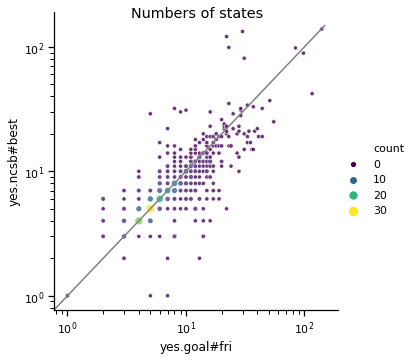

In [10]:
b.seaborn_scatter_plot("yes.goal#fri","yes.seminator#best",log=True)

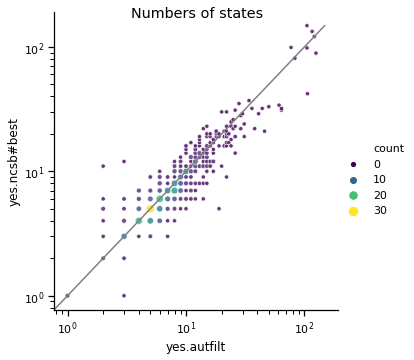

In [11]:
b.seaborn_scatter_plot("yes.spot","yes.seminator#best",log=True)

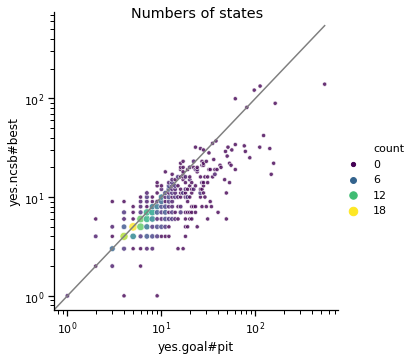

In [12]:
p = b.seaborn_scatter_plot("yes.goal#pit","yes.seminator#best", log=True)

## Without simplifications of Spot
GOAL#pit runs removing dead and unreachable states, roll probably does not create such states. The rest of the tools does not remove them.

We can observe that Fribourg generates large ammount of unnecessary states before simplifications.

In [13]:
no_tools = [t.replace("yes","no") for t in tools]

In [14]:
gather_cumulative(benchmarks, tool_set=no_tools)

,literature_det,literature_sd,literature_nd,random_det,random_sd,random_nd
tool,,,,,,
no.autfilt,613,257,234,2442,3578,7623
no.buechic,1635,915,332,4704,6903,7639
no.goal#fri,1260,2518,3031,5054,17376,55089
no.goal#pit,772,1033,1113,2918,8500,20803
no.ncsb#best,804,439,654,3060,6446,20778


## Minimal automata
The following table shows for how many formulas each tool produces automaton that has the smallest number of states. The minimum ranges over the considered tools. The number in `min hits` shows how many times the same size as the smallest automaton was achieved. The number in `unique min hits` counts only cases where the given tool is the only tool with such a small automaton.

In [15]:
gather_mins(benchmarks, tool_set=no_tools)

### Time in seconds

In [16]:
gather_cumulative(benchmarks, col="time", tool_set=no_tools)

,literature_det,literature_sd,literature_nd,random_det,random_sd,random_nd
tool,,,,,,
no.autfilt,5.75997,1.5631,0.506391,17.5037,20.1102,20.9111
no.buechic,923.437,201.406,573.621,746.382,906.391,2373.79
no.goal#fri,717.746,363.339,245.052,1565.11,1833.91,2477.29
no.goal#pit,679.127,450.502,324.876,1544.54,2002.34,2849.87
no.ncsb#best,5.9429,1.6059,1.4125,17.6571,21.4792,26.2529


In [20]:
for t in ["nd", "sd", "det"]:
    bench = {n: b for n, b in benchmarks.items() if n[-3:].find(t) >= 0}
    display(t, gather_cumulative(bench, tools, col="time"))
    for b in bench.values():
        display(b.cross_compare(tools, col="time"))
    print("\n\n\n")

'nd'

,literature_nd,random_nd
tool,,
yes.autfilt,10.106,143.632
yes.buechic,603.545,2348.93
yes.goal#fri,263.876,2495.74
yes.goal#pit,302.677,2969.07
yes.ncsb#best,2.03465,321.401


,yes.autfilt,yes.ncsb#best,yes.goal#fri,yes.goal#pit,yes.buechic,V
yes.autfilt,nan,7,5,11,18,41
yes.ncsb#best,12,nan,6,15,18,51
yes.goal#fri,12,9,nan,15,19,55
yes.goal#pit,6,2,1,nan,16,25
yes.buechic,2,2,1,4,nan,9


,yes.autfilt,yes.ncsb#best,yes.goal#fri,yes.goal#pit,yes.buechic,V
yes.autfilt,nan,214,220,347,373,1154
yes.ncsb#best,242,nan,240,361,400,1243
yes.goal#fri,233,230,nan,361,387,1211
yes.goal#pit,108,100,94,nan,286,588
yes.buechic,126,98,113,213,nan,550


'sd'

,literature_sd,random_sd
tool,,
yes.autfilt,1.65173,21.154
yes.buechic,204.616,904.794
yes.goal#fri,350.423,1836.8
yes.goal#pit,453.724,2019.01
yes.ncsb#best,1.68781,22.6863


,yes.autfilt,yes.ncsb#best,yes.goal#fri,yes.goal#pit,yes.buechic,V
yes.autfilt,nan,11,22,18,46,97
yes.ncsb#best,15,nan,24,12,46,97
yes.goal#fri,12,2,nan,10,44,68
yes.goal#pit,9,0,16,nan,41,66
yes.buechic,3,3,4,8,nan,18


,yes.autfilt,yes.ncsb#best,yes.goal#fri,yes.goal#pit,yes.buechic,V
yes.autfilt,nan,108,237,210,483,1038
yes.ncsb#best,142,nan,246,215,486,1089
yes.goal#fri,109,91,nan,140,473,813
yes.goal#pit,72,56,161,nan,451,740
yes.buechic,13,14,24,48,nan,99


'det'

,literature_det,random_det
tool,,
yes.autfilt,6.69195,17.2809
yes.buechic,1863.91,740.333
yes.goal#fri,696.468,1537.18
yes.goal#pit,698.411,1568.25
yes.ncsb#best,7.32493,18.077


,yes.autfilt,yes.ncsb#best,yes.goal#fri,yes.goal#pit,yes.buechic,V
yes.autfilt,nan,14,15,12,152,193
yes.ncsb#best,14,nan,8,4,148,174
yes.goal#fri,15,13,nan,5,150,183
yes.goal#pit,15,11,6,nan,150,182
yes.buechic,0,4,2,2,nan,8


,yes.autfilt,yes.ncsb#best,yes.goal#fri,yes.goal#pit,yes.buechic,V
yes.autfilt,nan,64,45,46,494,649
yes.ncsb#best,9,nan,30,16,489,544
yes.goal#fri,20,57,nan,36,491,604
yes.goal#pit,11,48,21,nan,491,571
yes.buechic,0,5,3,3,nan,11


In [17]:
for t in ["nd", "sd", "det"]:
    bench = {n: b for n, b in benchmarks.items() if n[-3:].find(t) >= 0}
    display(t, gather_cumulative(bench, no_tools))
    for b in bench.values():
        display(b.cross_compare(no_tools))
    print("\n\n\n")

'nd'

,literature_nd,random_nd
tool,,
yes.autfilt,197,5507
yes.buechic,328,6343
yes.goal#fri,196,5359
yes.goal#pit,261,7615
yes.ncsb#best,195,5082


,no.autfilt,no.ncsb#best,no.goal#fri,no.goal#pit,no.buechic,V
no.autfilt,nan,19,20,18,17,74
no.ncsb#best,1,nan,17,8,5,31
no.goal#fri,0,3,nan,0,4,7
no.goal#pit,2,12,19,nan,7,40
no.buechic,3,15,16,13,nan,47


,no.autfilt,no.ncsb#best,no.goal#fri,no.goal#pit,no.buechic,V
no.autfilt,nan,443,500,450,363,1756
no.ncsb#best,56,nan,475,328,211,1070
no.goal#fri,0,25,nan,2,25,52
no.goal#pit,44,163,496,nan,166,869
no.buechic,136,289,475,333,nan,1233


'sd'

,literature_sd,random_sd
tool,,
yes.autfilt,190,2892
yes.buechic,833,5766
yes.goal#fri,290,3367
yes.goal#pit,331,3389
yes.ncsb#best,210,2828


,no.autfilt,no.ncsb#best,no.goal#fri,no.goal#pit,no.buechic,V
no.autfilt,nan,28,49,48,45,170
no.ncsb#best,8,nan,49,38,42,137
no.goal#fri,0,0,nan,1,25,26
no.goal#pit,0,3,47,nan,35,85
no.buechic,4,7,23,13,nan,47


,no.autfilt,no.ncsb#best,no.goal#fri,no.goal#pit,no.buechic,V
no.autfilt,nan,372,500,446,471,1789
no.ncsb#best,50,nan,500,295,369,1214
no.goal#fri,0,0,nan,0,107,107
no.goal#pit,27,107,500,nan,314,948
no.buechic,28,131,391,177,nan,727


'det'

,literature_det,random_det
tool,,
yes.autfilt,611,2439
yes.buechic,1388,3632
yes.goal#fri,627,2493
yes.goal#pit,617,2454
yes.ncsb#best,622,2473


,no.autfilt,no.ncsb#best,no.goal#fri,no.goal#pit,no.buechic,V
no.autfilt,nan,141,152,113,152,558
no.ncsb#best,0,nan,150,55,144,349
no.goal#fri,0,0,nan,0,90,90
no.goal#pit,0,77,152,nan,150,379
no.buechic,0,7,61,2,nan,70


,no.autfilt,no.ncsb#best,no.goal#fri,no.goal#pit,no.buechic,V
no.autfilt,nan,449,500,433,500,1882
no.ncsb#best,0,nan,490,72,477,1039
no.goal#fri,0,8,nan,6,207,221
no.goal#pit,0,142,492,nan,497,1131
no.buechic,0,22,288,3,nan,313


## Errors
We can observe several timeouts (120s) and 2 parsing errors on GOAL configurations. These occur on 2 formulas equivalent to false. GOAL does not see the automata as Büchi.

In [18]:
for name, b in benchmarks.items():
    display(name, b.get_error_counts())

'literature_det'

,timeout,parse error,incorrect,crash,no output
no.buechic,4,0,0,0,0
yes.buechic,4,0,0,0,0


'literature_sd'

,timeout,parse error,incorrect,crash,no output
no.buechic,1,0,0,0,0
no.goal#fri,1,0,0,0,0
no.goal#pit,2,0,0,0,0
yes.buechic,1,0,0,0,0
yes.goal#fri,1,0,0,0,0
yes.goal#pit,1,0,0,0,0


'literature_nd'

,timeout,parse error,incorrect,crash,no output
no.buechic,2,0,0,1,0
no.goal#fri,1,0,0,0,0
no.goal#pit,1,0,0,0,0
yes.buechic,2,0,0,0,0
yes.goal#fri,1,0,0,0,0
yes.goal#pit,1,0,0,0,0


'random_det'

,timeout,parse error,incorrect,crash,no output
no.goal#fri,0,2,0,0,0
no.goal#pit,0,2,0,0,0
yes.goal#fri,0,0,0,2,0
yes.goal#pit,0,0,0,2,0


'random_sd'

,timeout,parse error,incorrect,crash,no output
tool,,,,,


'random_nd'

,timeout,parse error,incorrect,crash,no output
no.buechic,3,0,0,0,0
no.goal#fri,2,0,0,0,0
no.goal#pit,4,0,0,0,0
yes.autfilt,1,0,0,0,0
yes.buechic,3,0,0,0,0
yes.goal#fri,3,0,0,0,0
yes.goal#pit,5,0,0,0,0
yes.ncsb#best,1,0,0,0,0
yes.ncsb#pldi,1,0,0,0,0
yes.ncsb#spot,1,0,0,0,0
